# This notebook constitutes deliverable 1 for the final project of DSTA 5509: Supervised Learning.

## The Github repo for this project (deliverable 3) is also attached here:
Github: https://github.com/n-cambria/MS-Sup-fin
___

# Introduction and Data Sourcing



### Background
For numerous years, Heart Attack has been the leading cause of death in the United States, accounting for 20%+ of the total national fatalities.  As of 2023, close to 800,000 deaths could be attributed to this acute condition anually (https://www.cdc.gov/heart-disease/data-research/facts-stats/index.html).  While much of this is reasonably attributable to chronic heart disease due to numerous health factors such as tobacco use or obesity, the ability to render proper care when confronted with this condition is of the utmost importance.  

Here, a dataset from the UCI Machine Learning Repository is used to assess proximal treatment and its apparent contribution to outcome.  Numerous factors will be assessed via Logistic Regression and gradient boosting in an attempt to find the most significant interventions which tend to associate with better patient outcomes.  Base logistic regression from sklearn will be used for the former, and a gradient boosting package called 'catboost' will be used for the latter.  This analysis will be restricted to treatments before and upon immediate admittance, and our target will be binary classification as to whether the patient lived or died.

### Data Sourcing
The dataset 'Myocardial infarction complications' from the UCI ML Repo is used here; it can be either imported via a python script or downloaded as a hard copy.  In this case, it will be imported to aid in reproduction of the below methodology.  This dataset examines a large number of factors and ultimately yields a multi-class response variable which encapsulates outcome.

Full dataset available here: https://archive.ics.uci.edu/dataset/579/myocardial+infarction+complications

Full citation here:

>Golovenkin, S., Shulman, V., Rossiev, D., Shesternya, P., Nikulina, S., Orlova, Y., & Voino-Yasenetsky, V. (2020). Myocardial infarction complications [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C53P5M.

### The below cell installs the UCI ML Repo package and loads the data; this cell should only be run once if this method of loading is used.

In [9]:
# install uci package and load data
# !pip install ucimlrepo

# from ucimlrepo import fetch_ucirepo 
  
# # fetch dataset 
# myocardial_infarction_complications = fetch_ucirepo(id=579) 
  
# # data (as pandas dataframes) 
# X = myocardial_infarction_complications.data.features 
# y = myocardial_infarction_complications.data.targets 

### The below cell reads the data directly from github.

In [18]:
data = pd.read_csv(r"https://raw.githubusercontent.com/n-cambria/MS-Sup-fin/refs/heads/main/midata.csv")

X = data.iloc[:, :111]
y = data.iloc[:, 111:]

In [44]:
# load various standard packages - if any of the below packages are not installed, please call "!pip install {package}"
# in an empty cell, and then continue
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

# Data Cleaning and EDA


In [16]:
print(f"Shape of X (predictors): {X.shape}")
print(f"Shape of y (response): {y.shape}")

Shape of X (predictors): (1700, 111)
Shape of y (response): (1700, 12)


We can see here that we initially have 111 predictor features and 12 responses for 1700 total entries.  We are principally focused on total mortal outcome; the source page for the dataset informs us that the last response, "LET_IS", categorizes cause of death from 0 to 7 where 0 means 'Alive', and 1 through 7 are various explicit causes of death.  Because we are seeking to assess treatments which most closely correlate with a patient's recovery, this is the only target response we will keep here.

In [19]:
# drop unwanted response columns
y = y.iloc[:,-1]

# convert all nonzero values to 1 and change name to be more intuitive
y[:] = (y > 0).astype(int)
y.name = 'death'

Our response is now a single boolean column where 0 indicates the patient lived, and 1 indicates the patient died.  We can now turn to our feature variables; we are concerned with proximal treatments, so the predictors will be restricted to only short-term interventions.

As noted previously, the predictor set is quite large, and many of the factors constitute patient history (as far as their recollection) or diagnostic test results.  We are seeking to assess active intervention success, so the "ECG rhythm at the time of admission to hospital" is not of concern here.  Some factors will be retained, such as age and previous heart attacks, but mostly we want to examine active interventions administered by either hospital staff or emergency response teams.  

Examining the data source page for column metadata, we can see that the following columns are of primary interest:

| Column Name | Description |
| :--- | :--- |
| TRENT_S_n | Use of Trental in ICU |
| TIKL_S_n | Use of Ticlid in ICU |
| ASP_S_n | Use of acetylsalicylic acid in ICU |
| GEPAR_S_n | Use of heparin in ICU |
| ANT_CA_S_n | Use of calcium channel blockers in ICU |
| B_BLOK_S_n | Use of beta blockers in ICU |
| LID_S_n | Use of lidocaine in ICU |
| NOT_NA_1_n | Uses of NSAIDs in ICU |
| NA_R_1_n | Use of opioids in ICU |
| NITR_S | Use of liquid nitrates in ICU |
| LID_KB | Use of lidocaine by emergency responders |
| NOT_NA_KB | Use of NSAIDs by emergency responders |
| NA_KB | Use of opioids by emergency responders |

These columns hold treatments attempted in the first hours of presentation, and are therefore the subject of this analysis.  In addition, we will retain obesity status and number of previous heart attacks

In [20]:
# keep explicitly desired columns
keep = [
    "AGE", "SEX", "INF_ANAM", "endocr_02", "TRENT_S_n", "TIKL_S_n", 
    "ASP_S_n", "GEPAR_S_n", "ANT_CA_S_n", "B_BLOK_S_n", "LID_S_n", 
    "NOT_NA_1_n", "NA_R_1_n", "NITR_S", "LID_KB", "NOT_NA_KB", "NA_KB"
]

X = X[keep]

# combine predictors with response 
df = pd.concat([X, y], axis = 1)

# rename columns to be more intuitive
names = {"INF_ANAM": "no_atk",
        "endocr_02": "obese",
        "TRENT_S_n": "trent",
        "TIKL_S_n": "tikl",
        "ASP_S_n": "asp",
        "GEPAR_S_n": "hep",
        "ANT_CA_S_n": "cal_b",
        "B_BLOK_S_n": "beta",
        "LID_S_n": "icu_lid",
        "NOT_NA_1_n": "icu_nsaid",
        "NA_R_1_n": "icu_op",
        "NITR_S": "nit",
        "LID_KB": "ems_lid",
        "NOT_NA_KB": "ems_nsaid",
        "NA_KB": "ems_op"}

df = df.rename(columns = names)

# view resulting dataframe
df.head()

,AGE,SEX,no_atk,obese,trent,tikl,asp,hep,cal_b,beta,icu_lid,icu_nsaid,icu_op,nit,ems_lid,ems_nsaid,ems_op,death
0,77.0,1,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,0
1,55.0,1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0
2,52.0,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,0
3,68.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0
4,60.0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Now that we have a coherant dataset, we can address missing values.  In the dataframe below, we can see that the vast majority of missing values are in the three columns corresponding to emergency response personnel administering drugs.  While rows with missing values in any of the other columns could be readily dropped (do to their infrequency), the counts in these three 'ems' columns is more concerning.  Based on the underlying data, three options appear most reasonable:

1. Omit these columns from the analysis.  This would serve to restrict consideration to only interventions which occurred at the hospital.
2. Replace the binary values with the most common value in the respective column.  This would serve to 'defer' the value to the preponderance of the EMS professionals in other cases.
3. Assess the distribution or proportion of ones in each column, and impute the remaining missing values randomly such that the total proportion is preserved.  This would serve to presume that any given case had more or less the same probability of having EMS intervention of a given type.

Because we are trying to assess apparent causal links, it seems best to go with option 1 and omit pre-hospital treatments from this particular analysis.  After doing so, any rows still with missing values will be dropped as there are at most 145 rows that fall into this category.

In [21]:
# count number of missing values for each column
missing = {}
for i in df.columns:
    missing[i] = df[i].isna().sum()
missing_counts = pd.DataFrame.from_dict(missing, orient='index', columns=['Missing Values'])

missing_counts.T.head(20)

,AGE,SEX,no_atk,obese,trent,tikl,asp,hep,cal_b,beta,icu_lid,icu_nsaid,icu_op,nit,ems_lid,ems_nsaid,ems_op,death
Missing Values,8,0,4,10,16,16,17,17,13,11,10,10,5,9,677,686,657,0


In [22]:
# drop ems columns and remove rows with nan in other columns

# drop ems cols
df = df.drop(columns = ['ems_lid', 'ems_nsaid', 'ems_op'])

# remove remaining missing value rows (after counting for comparison)
len_before = len(df)
mi = df.dropna()
len_after = len(mi)

print(f"Number of rows before dropping missing values: {len_before}")
print(f"Number of rows after dropping missing values: {len_after}")
print(f"Only {len_before - len_after} rows were removed.")

# view new dataframe which excludes ems columns and rows with missing values
mi.head()

Number of rows before dropping missing values: 1700
Number of rows after dropping missing values: 1656
Only 44 rows were removed.


,AGE,SEX,no_atk,obese,trent,tikl,asp,hep,cal_b,beta,icu_lid,icu_nsaid,icu_op,nit,death
0,77.0,1,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,55.0,1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
2,52.0,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,3.0,1.0,0.0,0
3,68.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,60.0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


Now that we have a clean dataset, let's examine the statistics of each predictor.  We'll go ahead and look at how many variables are binary and how many are categorical.

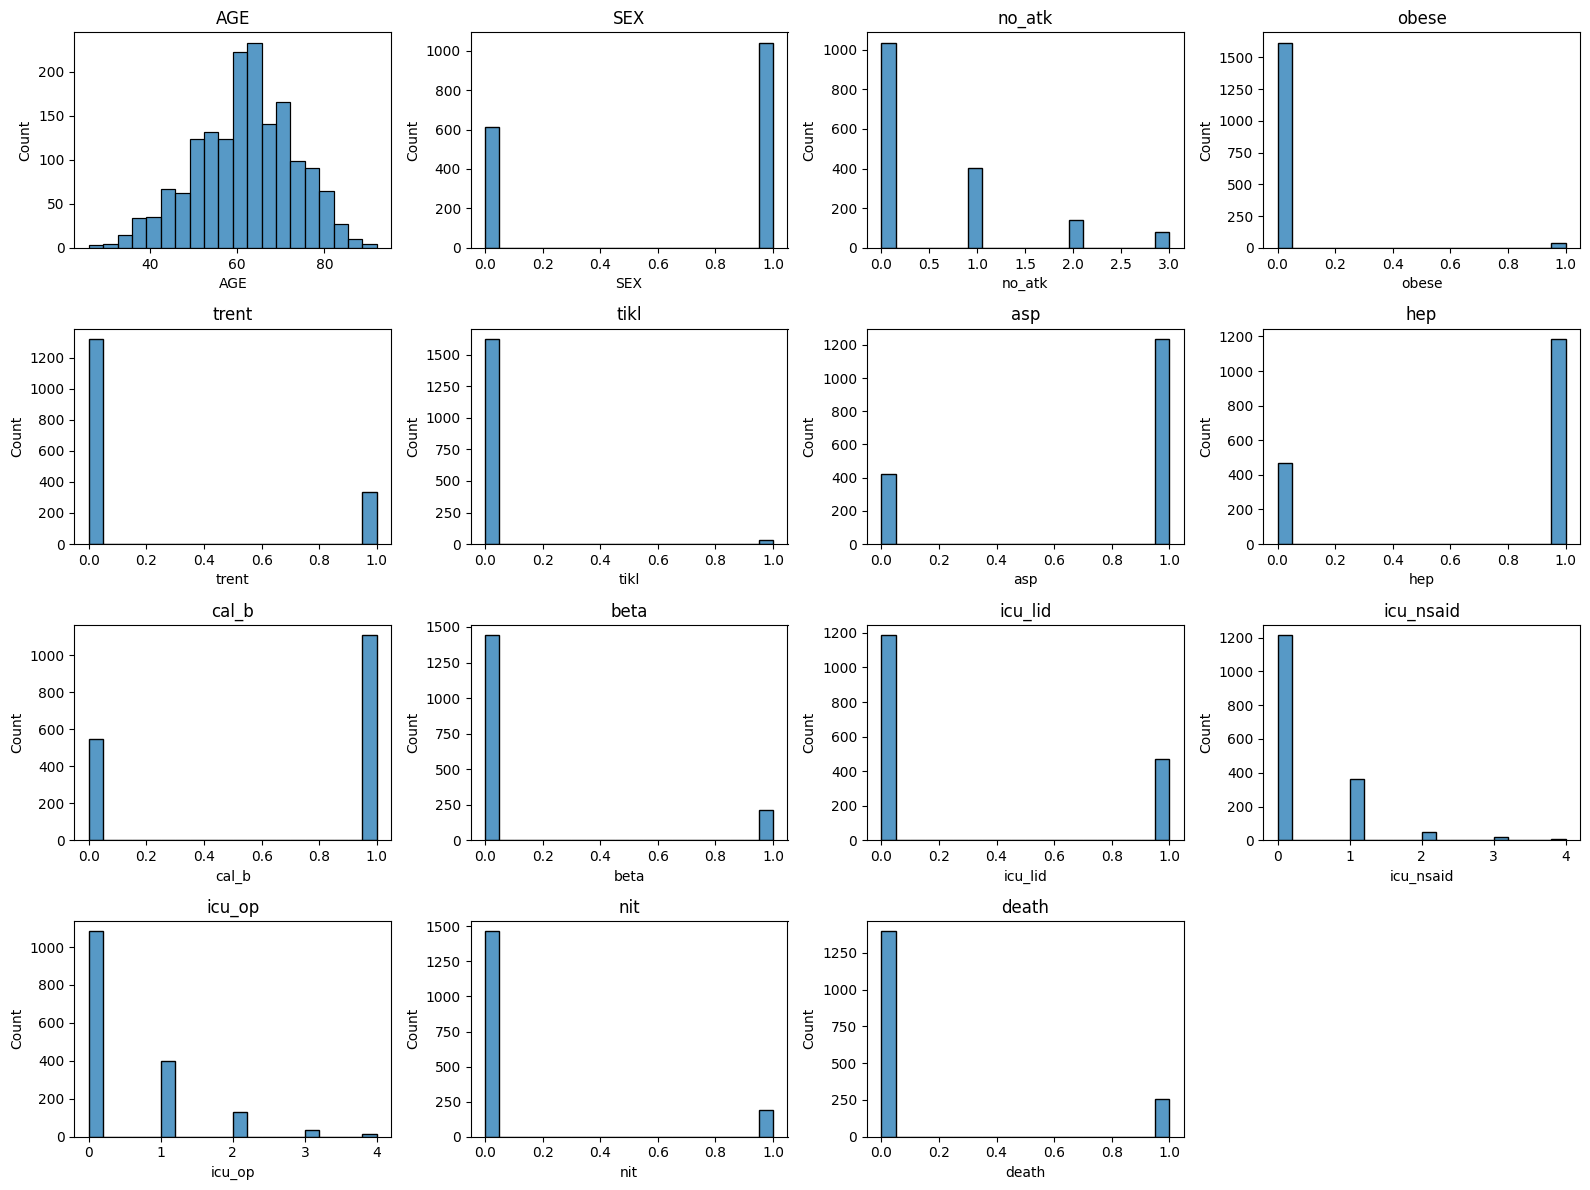

In [23]:
# set bounds for readable plot grid
num_cols = len(mi.columns)
cols_per_row = 4
num_rows = math.ceil(num_cols / cols_per_row)

# create total plot space as a grid
plt.figure(figsize=(cols_per_row * 4, num_rows * 3))

# loop through dataframe and plot each as a discrete histogram
for i, col in enumerate(mi.columns):
    plt.subplot(num_rows, cols_per_row, i + 1)
    sns.histplot(mi[col], kde=False, bins=20)
    plt.title(col)
    plt.tight_layout()

plt.show()

From these plots, we see that age, number of prior heart attacks (no_atk), number of doses of NSAIDs administered by ICU staff (icu_nsaid), and number of doses of opiods administered by ICU staff (icu_op) are the only categorical variable; all others are binary.  Because these categorical variables are generally progressive, i.e. three doses of opiods is three times as much of a given treatment than one dose, we can roll these features in without issue.  We are now ready to create training and test sets, and train models.

# Models and Results

First we have to split the data into training and test sets for the models.

In [30]:
# split data back into predictors and response
X = mi.drop(columns='death')
y = mi['death']

# further split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


## Logistic regression
First we'll train a logistic regression model and assess its accuracy

In [38]:
# use sklearn's Pipeline function to perform liblinear logistic regression across multiple steps
pipeline = Pipeline(steps=[('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))])

# fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# make predictions based on the test data
y_pred = pipeline.predict(X_test)

# predict probabilities
y_proba = pipeline.predict_proba(X_test)[:, 1]

# show summary of accuracy
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       280
           1       0.60      0.17      0.27        52

    accuracy                           0.85       332
   macro avg       0.73      0.58      0.59       332
weighted avg       0.82      0.85      0.82       332

ROC AUC Score: 0.771


This is a very respectable score.  We can feel confident that this model carries some reasonable predictive power.  Let's examine which factors tend to impact the outcome of the model the most.

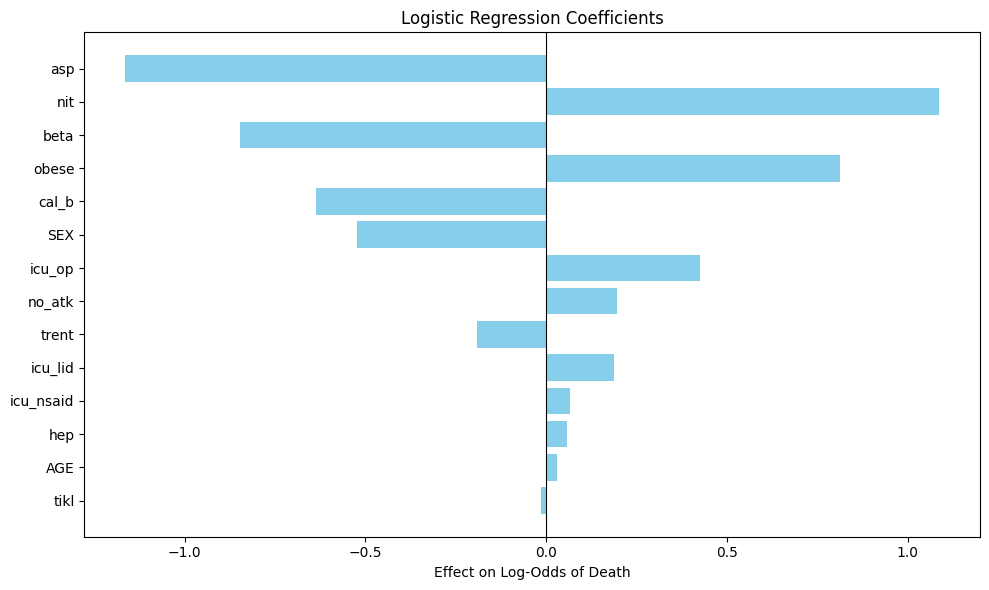

In [32]:
# get feature names
feature_names = X.columns

# get coefficients
coefs = pipeline_a.named_steps['logreg'].coef_[0]

# create comparative bar plot
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

# plot the figure
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Effect on Log-Odds of Death')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

This plot shows that the administration of aspirin by ICU staff was the factor which most significantly decreased the log-odds of death.  We also see that the use of beta blockers was correlated with better outcomes in this case.  The two factors which most strongly contributed to increasing the chances of death were the use of liquid nitrates and obesity.  The obesity factor is quite intuitive and not at all surprising, however the ICU staff usage of liquid nitrates would not have been assumed to increase the log-odds of death.  This presents an interesting deviation from our human intuition.

## Catboost Model
Now we can examine the Catboost model using the same training and testing data.  None of our features are continuous, so we have to denote our features explicitly as categorical.

In [41]:
# list of features
cats = X_train.columns.tolist()

# convert feature values to int - Catboost only handls str and int
X_train[cats] = X_train[cats].astype(int)
X_test[cats] = X_test[cats].astype(int)

# create gradient bost training and testing pools
train_pool = Pool(X_train, y_train, cat_features = cats)
test_pool = Pool(X_test, y_test, cat_features = cats)

# create and train model
cat_mod = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, loss_function='Logloss',
    eval_metric='AUC', random_seed=42, verbose=100)

cat_mod.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

0:	test: 0.5031593	best: 0.5031593 (0)	total: 149ms	remaining: 1m 14s
100:	test: 0.7491071	best: 0.7670330 (62)	total: 2.81s	remaining: 11.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.767032967
bestIteration = 62

Shrink model to first 63 iterations.


After training our model, we see that the model peaked in performance around iteration 62, and did not meaningfully improve after iteration 112.  The CatBoostClassifier automatically stopped at this point due to the detection of overfitting, which is seen when comparing the best score (at iteration 62) with the score at iteration 100.  Between iteration 62 and 100, the score actually decreased from 0.767 to 0.749.

Now we can go ahead and make predictions and test the model with our test set.

In [45]:
# make predictions on test data
cat_prob = cat_mod.predict_proba(X_test)[:, 1]
cat_pred = cat_mod.predict(X_test)

# show summary of accuracy
print("AUC: ", roc_auc_score(y_test, cat_prob))
print("Accuracy: ", accuracy_score(y_test, cat_pred))

AUC:  0.7670329670329671
Accuracy:  0.8313253012048193


This accuracy score is also quite respectable.  Similar to our logistic model, let's examine feature importance.

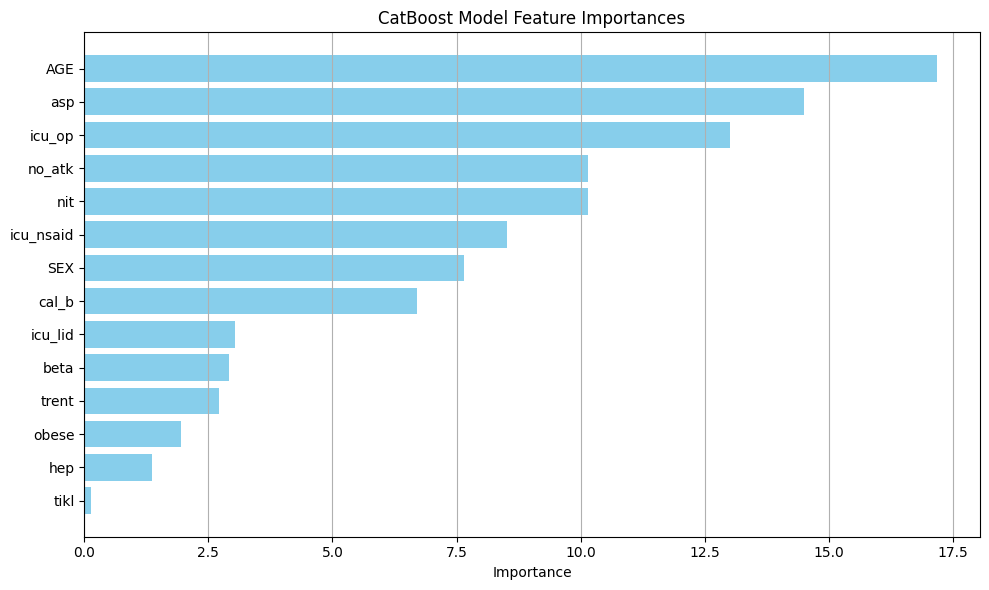

In [51]:
# get feature importance
features = cat_mod.get_feature_importance(prettified=True)

# plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    features['Feature Id'],
    features['Importances'],
    color='skyblue'
)
plt.xlabel('Importance')
plt.title('CatBoost Model Feature Importances')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Here, we see that age was identified as the most significant factor with the administration of aspirin being the second most significant.  This agrees both with our intuitive understanding and the results of our logistic regression model.  Interestingly, the obesity factor is quite low in impact for this model; this disagrees with both our intuitive understanding and our logistic regression model.  

Both of our models seemed to perform similarly; let's plot the ROC curve for each.

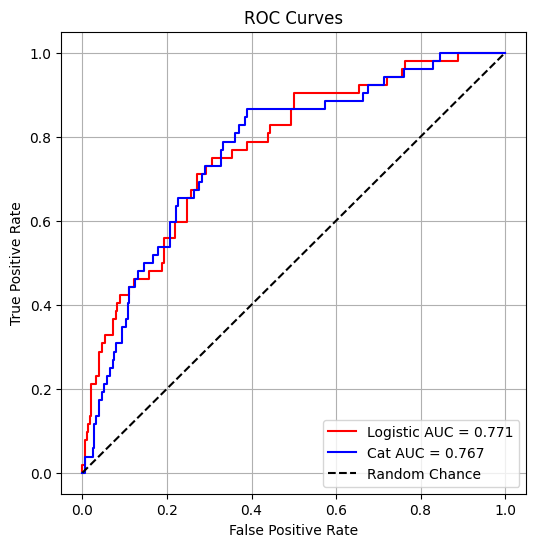

In [47]:
# recover true positive rate and false positive rate for the logistic model
fpr, tpr, _ = roc_curve(y_test, y_proba)

# calculate area under roc curve
roc_auc = auc(fpr, tpr)

# recover true/false for the gradient boost model
cfpr, ctpr, _ = roc_curve(y_test, cat_prob)

# calculate auc for the boosted model
c_roc_auc = roc_auc_score(y_test, cat_prob)

# plot roc
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'Logistic AUC = {roc_auc:.3f}', color='red')
plt.plot(cfpr, ctpr, label = f'Cat AUC = {c_roc_auc:.3f}', color = 'blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Both curves follow each other quite closely, and are undeniably better than random chance.  We can see from the total AUC of each model that the Logistic Regression model happened to perform better in this particular case.

# Conclusion

In total, both models generally agree on their conclusions.  The most significant factor identified which correlated with patient survival was the administration of Aspirin by the ICU medical staff.  This is consistent with years of general knowledge which has long-since identified Aspirin to be an effective early intervention for acute Myochardial Infarction.  The models disagreed with some secondary factors; notably, the regression model identified obesity as being a significant detrimental factor, while the gradient boosted model identified age to be more significant in this regard.  Both models achieved a respectable AUC score in the high 0.7s, and both had a solid accuracy of ~80 - 85%, with the logistic regression model winning slightly in both categories.  As is clear on the ROC AUC plot above, the regression model had a greater area under the ROC curve by 0.004, and visible earlier in the notebook, the regression model achieved an accuracy of 85% vs. 83% for the gradient boost model.  

Should this work be extended, several key questions arrise immediately.  In addition to logistic regression and gradient boosting, the performance of other models could be attempted.  Most notably, tree bagging could be compared to this boosting technique.  In addition to this, the outcomes which are assessed could be stratified.  The underlying data used here contains several outcomes which more specifically denote the outgoing condition of the patient both lethally and nonlethally.  Further, the columns with the treatments applied by emergency responders were dropped due to their high number of missing values.  If one can recover the reason why these values were missing, and thereby more effectively impute these values, this earlier intervention data could show significant effect in outcome which is omitted here.  